In [1]:
########################################
## import packages
########################################
%matplotlib inline
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,  Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


import gc
import seaborn as sns
from snownlp import SnowNLP
from collections import Counter
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score


import cPickle
import gensim
import math
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis


import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/scikit_learn-0.18.1-py2.7-linux-x86_64.egg/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
########################################
## set directories and parameters
########################################
BASE_DIR = 'data/'
# EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300.bin'
EMBEDDING_FILE = BASE_DIR + 'wiki.en.bin'
TRAIN_DATA_FILE = BASE_DIR + 'cor_train.csv'
TEST_DATA_FILE = BASE_DIR + 'cor_test.csv'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.02

# num_lstm = np.random.randint(175, 275)
# num_dense = np.random.randint(100, 150)
# rate_drop_lstm = 0.15 + np.random.rand() * 0.25
# rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

In [3]:
data_1 = np.loadtxt("data/data_1.csv", delimiter=",")
data_2 = np.loadtxt("data/data_2.csv", delimiter=",")
test_data_1 = np.loadtxt("data/test_data_1.csv", delimiter=",")
test_data_2 = np.loadtxt("data/test_data_2.csv", delimiter=",")
labels = np.loadtxt("data/labels.csv", delimiter=",")

In [4]:
x_train = pd.read_pickle('data/x_train_norm.pkl')
x_test = pd.read_pickle('data/x_test_norm.pkl')

In [5]:
x_train_other = pd.read_csv('data/train_features_mix.csv')
x_train = pd.concat([x_train_other.ix[:,2:],x_train], axis=1)
x_test_other = pd.read_csv('data/test_features_mix.csv')
x_test = pd.concat([x_test_other.ix[:,2:],x_test], axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler

data_columns = x_train.columns
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)
x_train['norm_wmd'] = x_train['norm_wmd'].replace(np.inf, 1.48)
x_test['norm_wmd'] = x_test['norm_wmd'].replace(np.inf, 1.48)
x_train['wmd'] = x_train['wmd'].replace(np.inf, 6.2)
x_test['wmd'] = x_test['wmd'].replace(np.inf, 6.2)

ss = StandardScaler()
ss.fit(np.vstack((x_train, x_test)))
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

x_train = pd.DataFrame(data=x_train, columns=data_columns)
x_test = pd.DataFrame(data=x_test, columns=data_columns)

In [7]:
########################################
## sample train/validation data
########################################

np.random.seed(1234)
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))

data_3_train = np.vstack((x_train.values[idx_train],x_train.values[idx_train]))
data_3_val = np.vstack((x_train.values[idx_val],x_train.values[idx_val]))

labels_train = np.concatenate((labels[idx_train], labels[idx_train]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))


weight_val = np.ones(len(labels_val))

if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344
    class_weight = {0: 1.309028344, 1: 0.472001959}
    

In [8]:
num_lstm = 250
num_dense = 300
rate_drop_lstm = 0.5
rate_drop_dense = 0.4

STAMP = 'FastTest_lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

In [33]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [9]:
########################################
## index word vectors
########################################
print('Indexing word vectors')

# word2vec = KeyedVectors.load_fasttest_format('data/', encoding='utf8')
from gensim.models.wrappers import FastText
word2vec = FastText.load_word2vec_format('data/wiki.en.vec')
print('Found %s word vectors of word2vec' % len(word2vec.vocab))


Indexing word vectors
Found 2519370 word vectors of word2vec


In [34]:
########################################
## text to sequence numbers
########################################
train_1 = [] 
train_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        train_1.append(text_to_wordlist(values[3]))
        train_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in cor_train.csv' % len(train_1))

test_1 = []
test_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_1.append(text_to_wordlist(values[1]))
        test_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print('Found %s texts in cor_test.csv' % len(test_1))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_1 + train_2 + test_1 + test_2)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

np.save('data/fasttest_embedding_matrix.npy',embedding_matrix)
embedding_matrix = np.load('data/fasttest_embedding_matrix.npy')

Found 404290 texts in cor_train.csv
Found 2345796 texts in cor_test.csv
Found 120500 unique tokens
Preparing embedding matrix
Null word embeddings: 27016


In [10]:
embedding_matrix = np.load('data/fasttest_embedding_matrix.npy')
nb_words = 120501

In [14]:
########################################
## define the model structure
########################################
os.environ["CUDA_VISIBLE_DEVICES"]="2"

embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer =  Bidirectional(LSTM(num_lstm, \
                                 dropout=rate_drop_lstm, \
                                 recurrent_dropout=rate_drop_lstm))

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

z1 = Input(shape=(x_train.shape[1],), dtype='float32')
z1_dense = Dense(num_dense/2, activation=act)(z1)

merged = concatenate([x1, y1, z1_dense])
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [15]:
########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input, z1], \
        outputs=preds)
# bst_model_path = 'models/FastTest_lstm_250_300_0.50_0.40.h5'
bst_model_path = 'models/FastTest_lstm_250_300_0.50_0.40_74dims_nobalance.h5'
# model.load_weights(bst_model_path)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
#model.summary()
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
# bst_model_path = 'models/'+ STAMP + '.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_loss',save_best_only=True, save_weights_only=True)
# model.load_weights(bst_model_path)
hist = model.fit([data_1_train, data_2_train, data_3_train], labels_train, \
        validation_data=([data_1_val, data_2_val, data_3_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        callbacks=[early_stopping, model_checkpoint])


FastTest_lstm_250_300_0.50_0.40
Train on 792408 samples, validate on 16172 samples
Epoch 1/200
792408/792408 [==============================] - 236s - loss: 0.3132 - acc: 0.8492 - val_loss: 0.2514 - val_acc: 0.8715
Epoch 2/200
792408/792408 [==============================] - 234s - loss: 0.2585 - acc: 0.8793 - val_loss: 0.2057 - val_acc: 0.8873
Epoch 3/200
792408/792408 [==============================] - 235s - loss: 0.2467 - acc: 0.8852 - val_loss: 0.1959 - val_acc: 0.8960
Epoch 4/200
792408/792408 [==============================] - 234s - loss: 0.2391 - acc: 0.8891 - val_loss: 0.1962 - val_acc: 0.8948
Epoch 5/200
792408/792408 [==============================] - 237s - loss: 0.2323 - acc: 0.8926 - val_loss: 0.2174 - val_acc: 0.8948
Epoch 6/200
792408/792408 [==============================] - 238s - loss: 0.2271 - acc: 0.8955 - val_loss: 0.1990 - val_acc: 0.8984
Epoch 7/200
792408/792408 [==============================] - 238s - loss: 0.2229 - acc: 0.8974 - val_loss: 0.1964 - val_acc: 

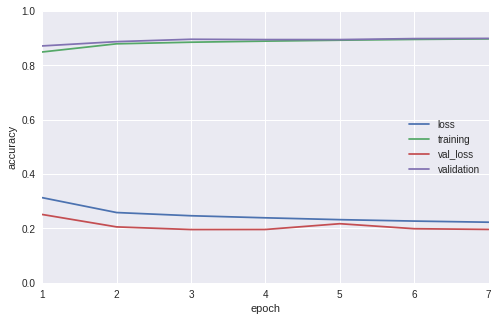

In [16]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in hist.epoch ],
                    'training': hist.history['acc'],
                    'validation': hist.history['val_acc'],
                    'loss': hist.history['loss'],
                   'val_loss': hist.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [17]:
bst_val_score = min(hist.history['val_loss'])

########################################
## make the submission
########################################
model.load_weights(bst_model_path)

preds = model.predict([test_data_1, test_data_2, x_test.values], batch_size=5000, verbose=1)
preds += model.predict([test_data_2, test_data_1, x_test.values], batch_size=5000, verbose=1)
preds /= 2

STAMP = '_lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

test_ids = np.arange(len(preds))
submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('predictions/'+'FastText_44dims_norebalance_'+ '%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)


2345796/2345796 [==============================] - 228s   


In [18]:
# bst_val_score = min(hist.history['val_loss'])

########################################
## make the submission
########################################
model.load_weights(bst_model_path)

preds = model.predict([data_1, data_2, x_train.values], batch_size=5000, verbose=1)
preds += model.predict([data_2, data_1, x_train.values], batch_size=5000, verbose=1)
preds /= 2

test_ids = np.arange(len(preds))
submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('predictions/'+'FastText_Test'+'.csv', index=False)


404290/404290 [==============================] - 40s    


NameError: name 'bst_val_score' is not defined

In [19]:
submission.to_csv('predictions/'+'FastText_Test'+'.csv', index=False)

In [40]:
import pandas as pd
a_name = 'predictions/combine-xgb-fasttest'
b_name = 'predictions/FastText_44dims_0.1608__lstm_250_300_0.50_0.40'
a = pd.read_csv(a_name + '.csv')
b = pd.read_csv(b_name + '.csv')

ids = a['test_id'].values
cfd = (a['is_duplicate'].values + b['is_duplicate'].values)/2.0

comb = pd.DataFrame({'test_id':ids, 'is_duplicate':cfd})

comb.to_csv('predictions/combine-xgb-fasttest-44dims.csv', index=False)